## Load libraries and Data

In [2]:
# Libraries
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold
from scipy.stats import spearmanr, pearsonr
from tqdm import tqdm
import matplotlib.pyplot as plt

# Constant Variables
RANDOM_SEED = 26
np.random.seed(RANDOM_SEED)
BASE_DIR = os.getcwd()  # Works in Jupyter
print(BASE_DIR)



c:\Users\Zita\Repositories\affective-states\notebooks


In [3]:
def open_data(file_name):
    relative_path = "../data/processed/"  
    remove_cols =  ['device', 'ts_seg']
    y_labels = ['ar_seg', 'vl_seg']

    path = os.path.join(BASE_DIR, relative_path, file_name + "_data.pkl")
    if not os.path.exists(path):
        raise FileNotFoundError(f"File {path} does not exist.")
    with open(path, 'rb') as f:
        df = pd.read_pickle(f)

    df.drop(columns=remove_cols, inplace=True)
    X = df.drop(y_labels, axis=1).copy()
    y = df[y_labels].copy()

    X_train, X_test = np.split(X.sample(frac=1, random_state=RANDOM_SEED), [int(.8*len(X))])   #optional: select test set based on some ID numbers
    y_train, y_test = np.split(y.sample(frac=1, random_state=RANDOM_SEED), [int(.8*len(y))])
    
    return X_train, y_train, X_test, y_test

test, _, _, _, = open_data('min_max')
test.head()

c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,EDA_quality_idx,PPG_quality_idx,mean_filt_EDA,std_filt_EDA,max_filt_EDA,min_filt_EDA,mean_filt_EDA_dot,std_filt_EDA_dot,max_filt_EDA_dot,min_filt_EDA_dot,...,min_diff_hr_time,SDNN,rMSSD,n_peaks_EDA,mean_peak_amp_EDA,std_peak_amp_EDA,unc_seg,ID,d_quality,d_peak_EDA
50,0.044564,0.034436,0.180551,0.005676,0.184187,0.178543,0.523546,0.000859,0.004710,0.998685,...,0.402985,0.029516,0.034995,0.200000,0.179829,0.006123,4.0,28,1.0,1.0
1146,0.000000,0.000000,0.105542,0.025934,0.121738,0.091948,0.508363,0.002452,0.005951,0.996253,...,0.343284,0.054779,0.077377,0.033333,0.095171,0.000779,4.0,54,0.0,1.0
1157,0.000000,0.000000,0.375165,0.168900,0.581733,0.338106,0.663458,0.077028,0.084143,0.982976,...,0.507463,0.026163,0.034050,0.133333,0.378666,0.128188,4.0,53,0.0,1.0
1004,0.987171,0.000000,0.263243,0.014006,0.271140,0.253612,0.529762,0.013208,0.013831,0.993782,...,0.552239,0.049918,0.037661,0.133333,0.269373,0.009506,3.0,17,1.0,1.0
513,0.490209,0.561107,0.171715,0.054753,0.202545,0.131753,0.552536,0.020653,0.023041,0.991640,...,0.402985,0.008727,0.007075,0.133333,0.180515,0.041377,4.0,5,1.0,1.0


In [4]:
def regression_evaluation(y_test, y_pred):
    # Calculate MSE, RMSE, MAE, Spearman corr., Pearson corr., concordance correlation coefficient (CCC)
    mse = np.mean((y_test - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test - y_pred))
    spearman_corr, _ = spearmanr(y_test, y_pred)
    pearson_corr = pearsonr(np.asarray(y_test, dtype=float), np.asarray(y_pred, dtype=float)).statistic
    ccc = (2 * spearman_corr) / (1 + spearman_corr)
    return mse, rmse, mae, spearman_corr, pearson_corr, ccc

In [5]:
model_results = {
    "model": [],
    "data": [],
    "pred_label": [],
    "hyper_paramameter": [],
    "mean_squared_error": [],
    "root_mean_squared_error": [],
    "mean_absolute_error": [],
    "spearman_correlation": [],
    "pearson_correlation": [],
    "concordance_correlation_coefficient": []
}

test_model_results = {
    "model": [],
    "data": [],
    "pred_label": [],
    "hyper_paramameter": [],
    "mean_squared_error": [],
    "root_mean_squared_error": [],
    "mean_absolute_error": [],
    "spearman_correlation": [],
    "pearson_correlation": [],
    "concordance_correlation_coefficient": []
}

data_list = ['processed', 'min_max', 'standardized', 'robust']

# Training and Evaluating

In [6]:
data = "processed"
model = Lasso(alpha=2)
label = "ar_seg"

X, y, _, _ = open_data(data)
groups = X["ID"]
X = X.drop("ID", axis=1)
y = y[label]

scores = []
gkf = GroupKFold(n_splits=3)

for train_idx, test_idx in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    # Print the depth of the model (average tree depth)
    # depths = [estimator.tree_.max_depth for estimator in model.estimators_]
    # print(f"Average tree depth: {np.mean(depths):.2f}, Max tree depth: {np.max(depths)}")

    y_pred = model.predict(X_test)
    result = regression_evaluation(y_test, y_pred)
    scores.append(result)
scores = np.mean(scores, axis=0)

params = ['alpha', 'l1_ratio', 'C', 'epsilon', 'max_depth', 'learning_rate']
hyper_param = ', '.join(f"{p}={getattr(model, p)!r}" for p in params if hasattr(model, p))

results = [model.__class__.__name__, data, label, hyper_param] + list(scores)

for key, value in zip(model_results.keys(), results):
    print(f"{key}: {value}")
    model_results[key].append(value)


model: Lasso
data: processed
pred_label: ar_seg
hyper_paramameter: alpha=2, l1_ratio=1.0
mean_squared_error: 1.3397754843367158
root_mean_squared_error: 1.1568817728485898
mean_absolute_error: 0.9429093607633351
spearman_correlation: -0.053905925209318244
pearson_correlation: -0.06365145076864955
concordance_correlation_coefficient: -0.11398039554173141


c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
# Rewrite the code block above into a function

def train_and_evaluate(model, data, label, test=False, subset_cols=None):
    global model_results, test_model_results
    X, y, X_test, y_test = open_data(data)
    groups = X["ID"]
    X = X.drop("ID", axis=1)
    X_test = X_test.drop("ID", axis=1)

    if subset_cols is not None:
        X = X[subset_cols]
        X_test = X_test[subset_cols]
        
    y = y[label]
    y_test = y_test[label]

    scores = []
    gkf = GroupKFold(n_splits=3)
    
    if test:
        model.fit(X, y)
        y_pred = model.predict(X_test)
        scores = regression_evaluation(y_test, y_pred)
    else:
        for train_idx, val_idx in gkf.split(X, y, groups):
            X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            result = regression_evaluation(y_test, y_pred)
            scores.append(result)
        scores = np.mean(scores, axis=0)

    params = ['alpha', 'l1_ratio', 'C', 'epsilon', 'max_depth', 'learning_rate']
    hyper_param = ', '.join(f"{p}={getattr(model, p)!r}" for p in params if hasattr(model, p))

    results = [model.__class__.__name__, data, label, hyper_param] + list(scores)


    for key, value in zip(model_results.keys(), results):
        # print(f"{key}: {value}")
        if test:
            test_model_results[key].append(value)
        else:
            model_results[key].append(value)
    
    return np.array(y_test), np.array(y_pred)

train_and_evaluate(Ridge(0.5), 'min_max', 'ar_seg')

c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(array([5.0, 3.0, 2.0, 3.0, 4.0, 1.0, 2.0, 5.0, 4.0, 2.0, 3.0, 3.0, 4.0,
        4.0, 5.0, 4.0, 1.0, 4.0, 4.0, 4.0, 2.0, 3.0, 2.0, 3.0, 4.0, 5.0,
        3.0, 3.0, 5.0, 3.0, 3.0, 4.0, 1.0, 2.0, 4.0, 2.0, 4.0, 1.0, 3.0,
        2.0, 3.0, 4.0, 2.0, 4.0, 4.0, 4.0, 3.0, 4.0, 2.0, 4.0, 3.0, 4.0,
        5.0, 3.0, 4.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 2.0, 3.0, 4.0, 3.0,
        3.0, 3.0, 4.0, 2.0, 1.0, 5.0, 3.0, 5.0, 3.0, 1.0, 3.0, 5.0, 3.0,
        4.0, 3.0, 3.0, 1.0, 2.0, 2.0, 5.0, 3.0, 2.0, 3.0, 3.0, 4.0, 3.0,
        2.0, 2.0, 4.0, 3.0, 4.0, 1.0, 3.0, 1.0, 3.0, 3.0, 2.0, 2.0, 3.0,
        3.0, 4.0, 1.0, 5.0, 4.0, 2.0, 1.0, 3.0, 4.0, 4.0, 4.0, 4.0, 2.0,
        2.0, 4.0, 1.0, 4.0, 3.0, 1.0, 4.0, 3.0, 4.0, 2.0, 3.0, 4.0, 2.0,
        4.0, 3.0, 4.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 3.0, 1.0,
        4.0, 4.0, 3.0, 4.0, 5.0, 3.0, 2.0, 4.0, 3.0, 3.0, 4.0, 2.0, 3.0,
        1.0, 3.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 5.0, 5.0, 4.0, 4.0, 3.0,
        5.0, 3.0, 4.0, 4.0, 3.0, 4.0, 3.0, 4.0, 5.0

In [8]:
# Apply the function to all models
models = [Ridge(alpha=1), Ridge(alpha=0.75), Ridge(alpha=0.5),
          Lasso(alpha=1), Lasso(alpha=0.75), Lasso(alpha=0.5),
          ElasticNet(l1_ratio=0.5, alpha=1), ElasticNet(l1_ratio=0.25, alpha=1), ElasticNet(l1_ratio=0.75, alpha=1),
          SVR(C=1, epsilon=0.1), SVR(C=0.5, epsilon=0.1), SVR(C=1, epsilon=0.3), SVR(C=0.5, epsilon=0.3),
          RandomForestRegressor(max_depth=30), RandomForestRegressor(max_depth=20), RandomForestRegressor(max_depth=10),
          XGBRegressor(learning_rate=0.3),  XGBRegressor(learning_rate=0.2)]

for model in tqdm(models):
    for file_name in data_list:
        for label in ['ar_seg', 'vl_seg']:
            train_and_evaluate(model, file_name, label)

print("All the models have been trained and evaluated")

  0%|          | 0/18 [00:00<?, ?it/s]c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future

All the models have been trained and evaluated


In [9]:
# Save results to csv
file_name = 'base_regressors_3.csv'

results_df = pd.DataFrame(model_results)
results_path = os.path.join(BASE_DIR, "../results/" + file_name)
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure directory exists
results_df.to_csv(results_path, index=False)
print(f"Results saved to {file_name}")

Results saved to base_regressors_3.csv


# Testing

In [10]:
data = "min_max"
model = SVR(C=0.5, epsilon=0.3)
label = "ar_seg"

X, y, X_test, y_test = open_data(data)
groups = X["ID"]
X = X.drop("ID", axis=1)
y = y[label]
X_test = X_test.drop("ID", axis=1)
y_test = y_test[label]

model.fit(X, y)
y_pred = model.predict(X_test)
scores = regression_evaluation(y_test, y_pred)
params = ['alpha', 'l1_ratio', 'C', 'epsilon', 'max_depth', 'learning_rate']
hyper_param = ', '.join(f"{p}={getattr(model, p)!r}" for p in params if hasattr(model, p))

results = [model.__class__.__name__, data, label, hyper_param] + list(scores)

for key, value in zip(model_results.keys(), results):
    print(f"{key}: {value}")
    model_results[key].append(value)


model: SVR
data: min_max
pred_label: ar_seg
hyper_paramameter: C=0.5, epsilon=0.3
mean_squared_error: 1.4047568737850065
root_mean_squared_error: 1.185224398071946
mean_absolute_error: 0.9783405029213689
spearman_correlation: 0.021731548933405353
pearson_correlation: 0.10335041413242954
concordance_correlation_coefficient: 0.042538666748797395


c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [11]:
# Start writing results and find n best models and evaluate again on test set

SVR_vl_test, SVR_vl_pred = train_and_evaluate(SVR(C=0.5, epsilon=0.3), 'min_max', 'vl_seg', test=True)
RF_vl_test, RF_vl_pred = train_and_evaluate(RandomForestRegressor(max_depth=10), 'processed', 'vl_seg', test=True)
Lasso_vl_test, Lasso_vl_pred = train_and_evaluate(Lasso(alpha=1), 'processed', 'vl_seg', test=True)
Elastic_vl_test, Elastic_vl_pred = train_and_evaluate(ElasticNet(alpha=1, l1_ratio=0.75), 'processed', 'vl_seg', test=True)
Ridge_vl_test, Ridge_vl_pred = train_and_evaluate(Ridge(alpha=1), 'min_max', 'vl_seg', test=True)
XGB_vl_test, XGB_vl_pred = train_and_evaluate(XGBRegressor(max_depth=None, learning_rate=0.2), 'standardized', 'vl_seg', test=True)

SVR_ar_test, SVR_ar_pred = train_and_evaluate(SVR(C=0.25, epsilon=0.1), 'min_max', 'ar_seg', test=True)
Elastic_ar_test, Elastic_ar_pred = train_and_evaluate(ElasticNet(alpha=1, l1_ratio=0.25), 'robust', 'ar_seg', test=True)
Lasso_ar_test, Lasso_ar_pred = train_and_evaluate(Lasso(alpha=1), 'processed', 'ar_seg', test=True)
Ridge_ar_test, Ridge_ar_pred = train_and_evaluate(Ridge(alpha=1), 'min_max', 'ar_seg', test=True)
RF_ar_test, RF_ar_pred = train_and_evaluate(RandomForestRegressor(max_depth=30), 'processed', 'ar_seg', test=True)
XGB_ar_test, XGB_ar_pred = train_and_evaluate(XGBRegressor(max_depth=None, learning_rate=0.3), 'processed', 'ar_seg', test=True)


c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transp

In [12]:
# Save results to csv
file_name = 'base_regressors_trial.csv'

results_df = pd.DataFrame(test_model_results)
results_path = os.path.join(BASE_DIR, "../results/" + file_name)
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure directory exists
results_df.to_csv(results_path, index=False)
print(f"Results saved to {file_name}")

Results saved to base_regressors_trial.csv


# Visualization of test results

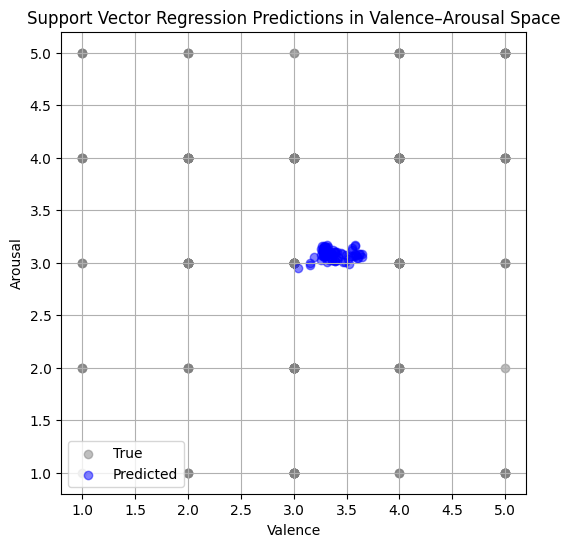

In [13]:
def scatter_vl_ar(true_valence, pred_valence, true_arousal, pred_arousal, title = "True vs. Predicted in Valence–Arousal Space"):
    plt.figure(figsize=(6, 6))
    plt.scatter(true_valence, true_arousal, color='gray', label='True', alpha=0.5)
    plt.scatter(pred_valence, pred_arousal, color='blue', label='Predicted', alpha=0.5)

    # for i in range(len(true_valence)):
    #     plt.plot([true_valence[i], pred_valence[i]],
    #              [true_arousal[i], pred_arousal[i]],
    #              color='lightblue', linewidth=0.5)

    plt.xlabel("Valence")
    plt.ylabel("Arousal")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    
scatter_vl_ar(SVR_vl_test, SVR_vl_pred, SVR_ar_test, SVR_ar_pred, title="Support Vector Regression Predictions in Valence–Arousal Space")

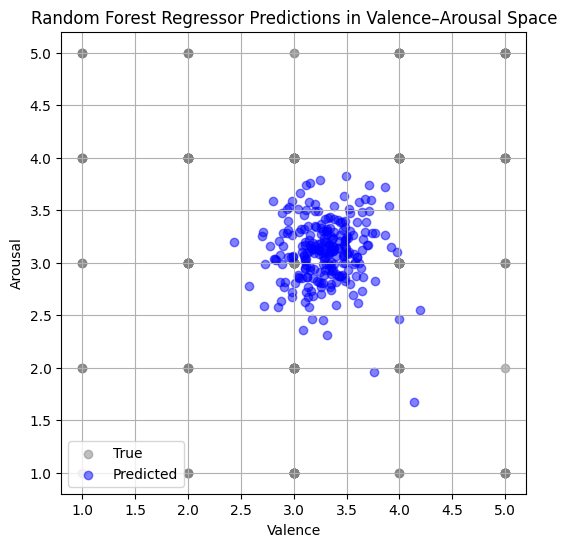

In [14]:
scatter_vl_ar(RF_vl_test, RF_vl_pred, RF_ar_test, RF_ar_pred, title="Random Forest Regressor Predictions in Valence–Arousal Space")

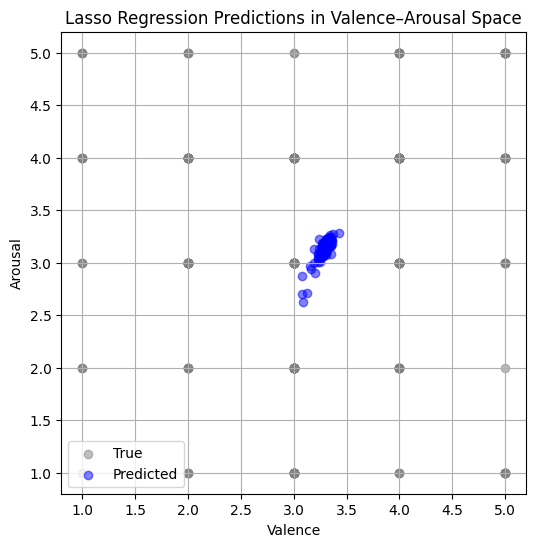

In [15]:
scatter_vl_ar(Lasso_vl_test, Lasso_vl_pred, Lasso_ar_test, Lasso_ar_pred, title="Lasso Regression Predictions in Valence–Arousal Space")

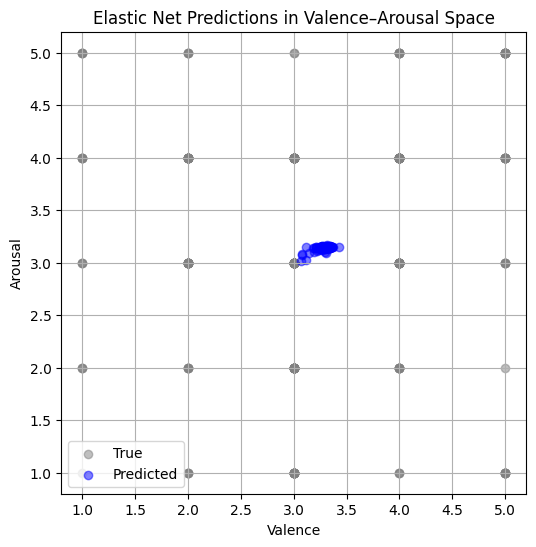

In [16]:
scatter_vl_ar(Elastic_vl_test, Elastic_vl_pred, Elastic_ar_test, Elastic_ar_pred, title="Elastic Net Predictions in Valence–Arousal Space")

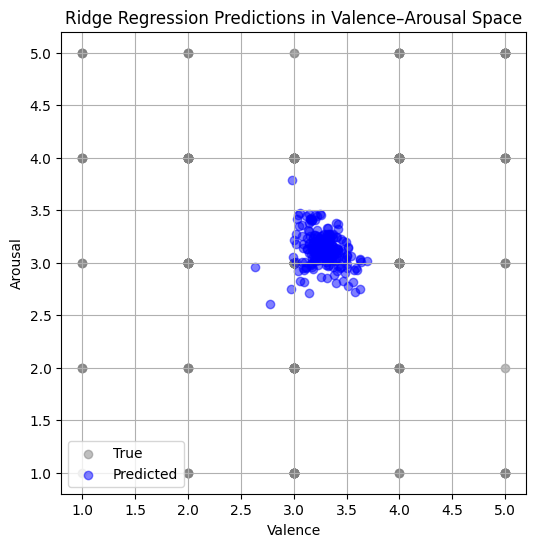

In [17]:
scatter_vl_ar(Ridge_vl_test, Ridge_vl_pred, Ridge_ar_test, Ridge_ar_pred, title="Ridge Regression Predictions in Valence–Arousal Space")

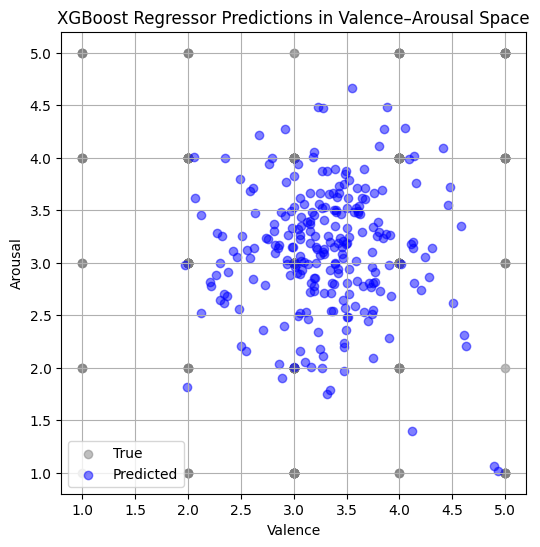

In [18]:
scatter_vl_ar(XGB_vl_test, XGB_vl_pred, XGB_ar_test, XGB_ar_pred, title="XGBoost Regressor Predictions in Valence–Arousal Space")

# Feature Importance Analysis

c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


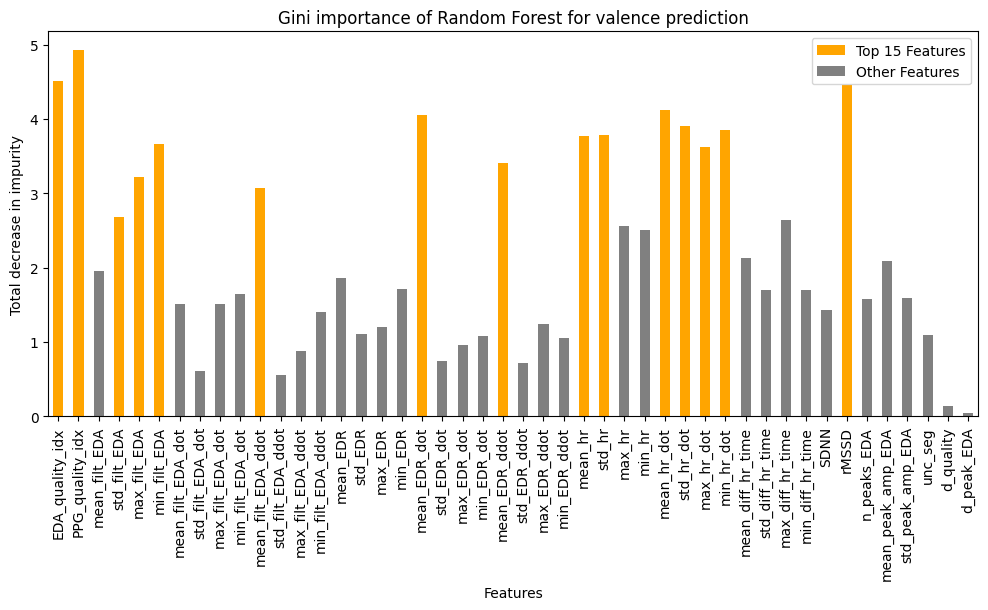

In [44]:
# example code, do not change this one, but copy
data = "processed"
model = RandomForestRegressor(max_depth=10)
label = "vl_seg"

X, y, X_test, y_test = open_data(data)
groups = X["ID"]
X = X.drop("ID", axis=1)
y = y[label]
X_test = X_test.drop("ID", axis=1)
y_test = y_test[label]

tree = model.fit(X, y)                                                                  # change this paragraph based on model
# Calculate total decrease in impurity for each feature
importances = np.array([estimator.tree_.impurity[0] - estimator.tree_.impurity.sum() for estimator in model.estimators_])
feature_importances = np.array([estimator.feature_importances_ for estimator in model.estimators_])
total_importance = feature_importances.sum(axis=0)
importances_series = pd.Series(total_importance, index=X.columns)

top_features = importances_series.nlargest(15)
# Color bars of top features orange and add a legend
bar_colors = ['orange' if feat in top_features.index else 'gray' for feat in importances_series.index]

fig, ax = plt.subplots(figsize=(12, 5))
importances_series.plot.bar(ax=ax, color=bar_colors)
ax.set_title("Gini importance of Random Forest for valence prediction")
ax.set_ylabel("Total decrease in impurity")
ax.set_xlabel("Features")

# Add legend
legend_elements = [Patch(facecolor='orange', label='Top 15 Features'),
                   Patch(facecolor='gray', label='Other Features')]
ax.legend(handles=legend_elements)



c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


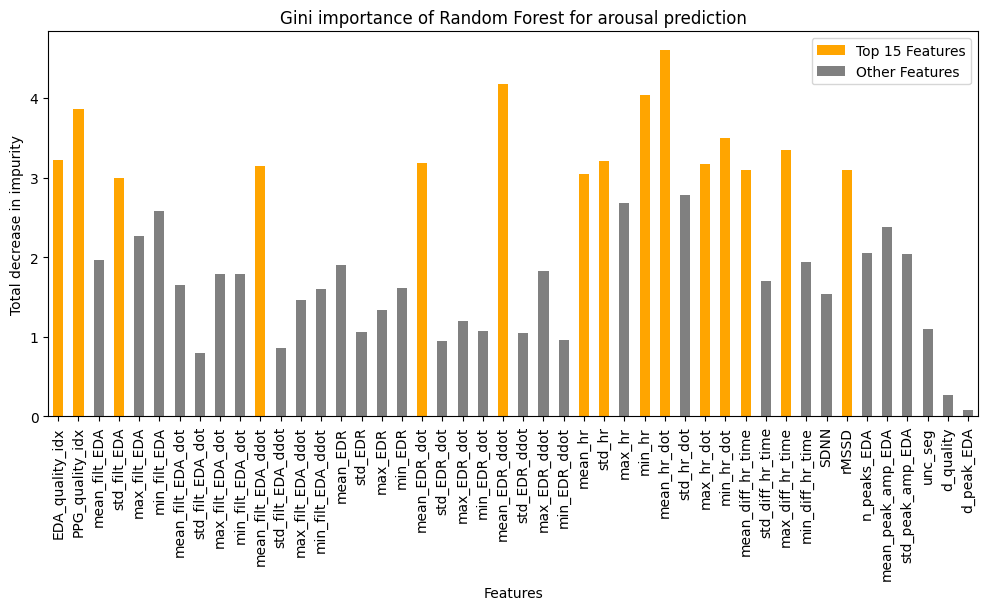

In [ ]:
# example code, do not change this one, but copy
data = "processed"
model = RandomForestRegressor(max_depth=30)
label = "ar_seg"

X, y, X_test, y_test = open_data(data)
groups = X["ID"]
X = X.drop("ID", axis=1)
y = y[label]
X_test = X_test.drop("ID", axis=1)
y_test = y_test[label]

tree = model.fit(X, y)
# Calculate total decrease in impurity for each feature
importances = np.array([estimator.tree_.impurity[0] - estimator.tree_.impurity.sum() for estimator in model.estimators_])
feature_importances = np.array([estimator.feature_importances_ for estimator in model.estimators_])
total_importance = feature_importances.sum(axis=0)
importances_series = pd.Series(total_importance, index=X.columns)

top_features = importances_series.nlargest(15)
# Color bars of top features orange and add a legend
bar_colors = ['orange' if feat in top_features.index else 'gray' for feat in importances_series.index]

fig, ax = plt.subplots(figsize=(12, 5))
importances_series.plot.bar(ax=ax, color=bar_colors)
ax.set_title("Gini importance of Random Forest for arousal prediction")
ax.set_ylabel("Total decrease in impurity")
ax.set_xlabel("Features")

# Add legend
legend_elements = [Patch(facecolor='orange', label='Top 15 Features'),
                   Patch(facecolor='gray', label='Other Features')]
ax.legend(handles=legend_elements)



c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


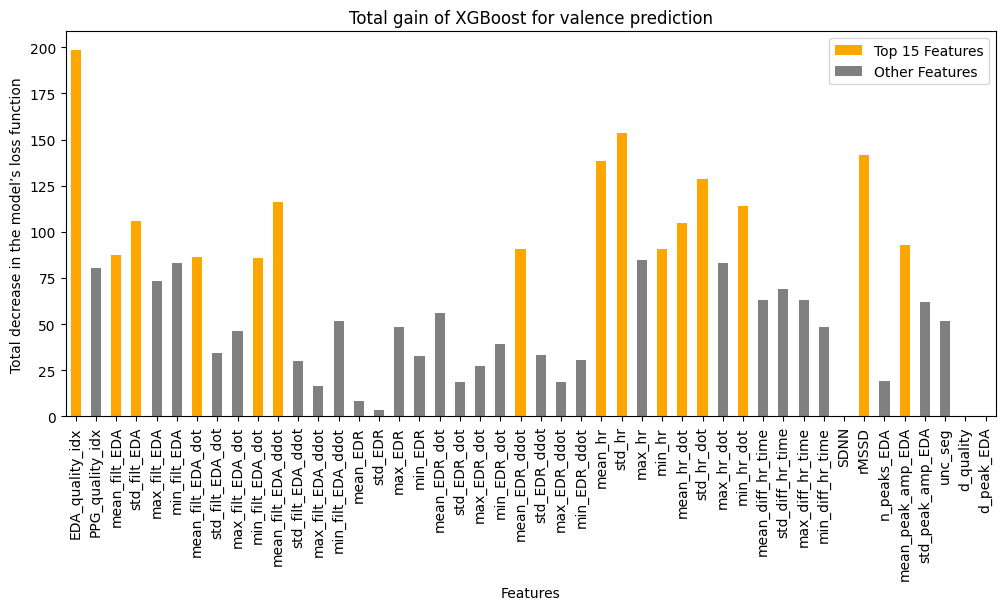

In [42]:
# example code, do not change this one, but copy
data = "processed"
model = XGBRegressor(max_depth=None, learning_rate=0.2)
label = "vl_seg"

X, y, X_test, y_test = open_data(data)
groups = X["ID"]
X = X.drop("ID", axis=1)
y = y[label]
X_test = X_test.drop("ID", axis=1)
y_test = y_test[label]

tree = model.fit(X, y)
# Get importances as a dictionary (feature_name: importance)
importances_dict = tree.get_booster().get_score(importance_type='total_gain')
# Convert to Series, reindex to X.columns (missing features get 0)
importances_series = pd.Series(importances_dict).reindex(X.columns, fill_value=0)

top_features = importances_series.nlargest(15)
# Color bars of top features orange and add a legend
bar_colors = ['orange' if feat in top_features.index else 'gray' for feat in importances_series.index]

fig, ax = plt.subplots(figsize=(12, 5))
importances_series.plot.bar(ax=ax, color=bar_colors)
ax.set_title("Total gain of XGBoost for valence prediction")
ax.set_ylabel("Total decrease in the model’s loss function")
ax.set_xlabel("Features")

# Add legend
legend_elements = [Patch(facecolor='orange', label='Top 15 Features'),
                   Patch(facecolor='gray', label='Other Features')]
ax.legend(handles=legend_elements)

c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


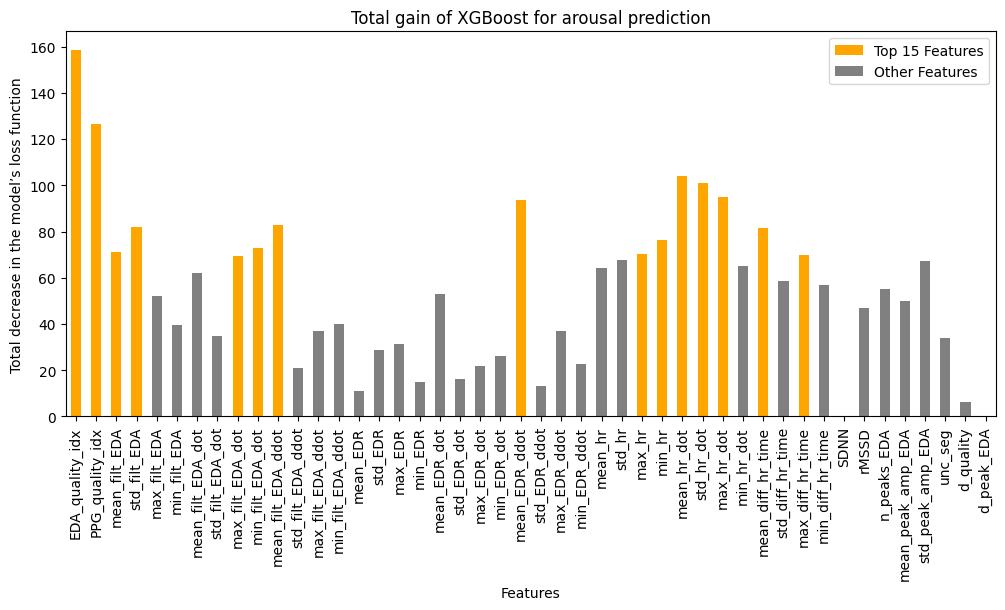

In [43]:
# example code, do not change this one, but copy
data = "processed"
model = XGBRegressor(max_depth=None, learning_rate=0.3)
label = "ar_seg"

X, y, X_test, y_test = open_data(data)
groups = X["ID"]
X = X.drop("ID", axis=1)
y = y[label]
X_test = X_test.drop("ID", axis=1)
y_test = y_test[label]

tree = model.fit(X, y)
# Get importances as a dictionary (feature_name: importance)
importances_dict = tree.get_booster().get_score(importance_type='total_gain')
# Convert to Series, reindex to X.columns (missing features get 0)
importances_series = pd.Series(importances_dict).reindex(X.columns, fill_value=0)

top_features = importances_series.nlargest(15)
# Color bars of top features orange and add a legend
bar_colors = ['orange' if feat in top_features.index else 'gray' for feat in importances_series.index]

fig, ax = plt.subplots(figsize=(12, 5))
importances_series.plot.bar(ax=ax, color=bar_colors)
ax.set_title("Total gain of XGBoost for arousal prediction")
ax.set_ylabel("Total decrease in the model’s loss function")
ax.set_xlabel("Features")

# Add legend
legend_elements = [Patch(facecolor='orange', label='Top 15 Features'),
                   Patch(facecolor='gray', label='Other Features')]
ax.legend(handles=legend_elements)


In [23]:
train_and_evaluate(RandomForestRegressor(max_depth=10), 'processed', 'vl_seg', test=True, subset_cols=RF_vl_top_features.index)

c:\Users\Zita\Repositories\affective-states\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(array([5.0, 4.0, 2.0, 2.0, 2.0, 3.0, 1.0, 1.0, 5.0, 3.0, 3.0, 3.0, 2.0,
        5.0, 5.0, 3.0, 1.0, 5.0, 1.0, 1.0, 4.0, 3.0, 3.0, 4.0, 2.0, 5.0,
        4.0, 3.0, 4.0, 5.0, 2.0, 5.0, 3.0, 3.0, 2.0, 2.0, 3.0, 4.0, 3.0,
        4.0, 3.0, 3.0, 4.0, 3.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 3.0, 4.0,
        2.0, 4.0, 2.0, 4.0, 5.0, 4.0, 3.0, 4.0, 4.0, 5.0, 2.0, 2.0, 5.0,
        3.0, 3.0, 5.0, 4.0, 4.0, 5.0, 5.0, 3.0, 4.0, 5.0, 5.0, 3.0, 5.0,
        3.0, 4.0, 4.0, 2.0, 4.0, 4.0, 3.0, 3.0, 5.0, 4.0, 4.0, 2.0, 5.0,
        5.0, 4.0, 4.0, 5.0, 4.0, 3.0, 2.0, 3.0, 2.0, 5.0, 5.0, 3.0, 2.0,
        2.0, 2.0, 3.0, 4.0, 3.0, 4.0, 3.0, 4.0, 3.0, 4.0, 3.0, 2.0, 3.0,
        5.0, 4.0, 2.0, 5.0, 3.0, 5.0, 2.0, 4.0, 1.0, 3.0, 3.0, 4.0, 3.0,
        3.0, 4.0, 2.0, 2.0, 1.0, 1.0, 4.0, 3.0, 5.0, 5.0, 2.0, 4.0, 3.0,
        3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 4.0, 4.0, 2.0, 3.0, 1.0,
        3.0, 5.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 2.0, 3.0, 5.0, 2.0, 3.0,
        5.0, 3.0, 3.0, 5.0, 3.0, 4.0, 1.0, 4.0, 2.0

# Model stacking

In [24]:
avg_vl_pred = 1/6 * RF_vl_pred + 1/6 * Elastic_vl_pred + 1/6 * Lasso_vl_pred + 1/6 * Ridge_vl_pred + 1/6 * XGB_vl_pred + 1/6 * SVR_vl_pred
avg_ar_pred = 1/6 * RF_ar_pred + 1/6 * Elastic_ar_pred + 1/6 * Lasso_ar_pred + 1/6 * Ridge_ar_pred + 1/6 * XGB_ar_pred + 1/6 * SVR_ar_pred

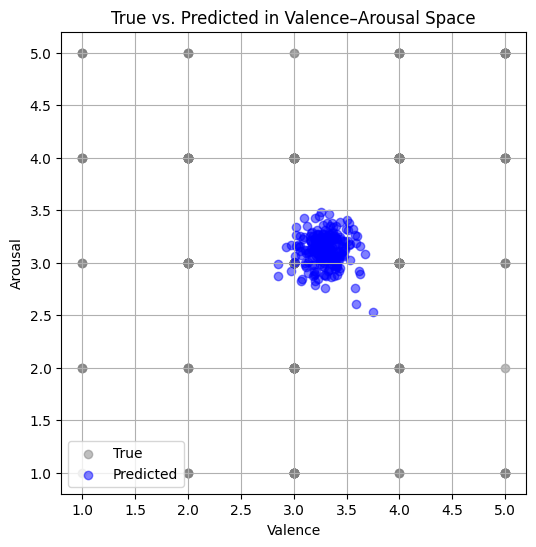

In [25]:
scatter_vl_ar(XGB_vl_test, avg_vl_pred, XGB_ar_test, avg_ar_pred)

In [26]:
# In next notebook, try model stacking
rates = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]
label = "vl_seg"

vl_models = [RF_vl_pred, Elastic_vl_pred, Lasso_vl_pred, Ridge_vl_pred, XGB_vl_pred, SVR_vl_pred]
ar_models = [RF_ar_pred, Elastic_ar_pred, Lasso_ar_pred, Ridge_ar_pred, XGB_ar_pred, SVR_ar_pred]
vl_test = RF_vl_test
ar_test = RF_ar_test

def ensemble_predictions(models, test_set, rates):
    predictions = sum(rate * model for rate, model in zip(rates, models))
    
    mse, rmse, mae, spearman, pearson, ccc = regression_evaluation(test_set, predictions)
    
    return (mse, rmse, mae, spearman, pearson, ccc)

ensemble_predictions(vl_models, vl_test, rates)

(np.float64(1.1636722313919274),
 np.float64(1.0787364049627357),
 np.float64(0.8850097140345659),
 np.float64(0.30348334900543766),
 np.float64(0.3130111166760022),
 np.float64(0.46564975185451585))

In [27]:
ensemble_results = {
    "model": [],
    "pred_label": [],
    "models": [],
    "rates": [],
    "mean_squared_error": [],
    "root_mean_squared_error": [],
    "mean_absolute_error": [],
    "spearman_correlation": [],
    "pearson_correlation": [],
    "concordance_correlation_coefficient": [],
    
}

rates = [
    [1/6, 1/6, 1/6, 1/6, 1/6, 1/6],  # Equal weights
    [3/8, 1/8, 1/8, 1/8, 1/8, 1/8],  # Emphasizing RF
    [1/8, 3/8, 1/8, 1/8, 1/8, 1/8],  # Emphasizing Elastic
    [1/8, 1/8, 3/8, 1/8, 1/8, 1/8],  # Emphasizing Lasso
    [1/8, 1/8, 1/8, 3/8, 1/8, 1/8],  # Emphasizing Ridge
    [1/8, 1/8, 1/8, 1/8, 3/8, 1/8],  # Emphasizing XGB
    [1/8, 1/8, 1/8, 1/8, 1/8, 3/8],   # Emphasizing SVR
    [3/10, 1/10, 1/10, 1/10, 3/10, 1/10],  # Emphasizing RF and XGB
    [1/2, 1/5, 1/5, 1/5, 1/5, 1/5],
    [1/5, 1/5, 1/5, 1/5, 1/2, 1/5], 
    [1/2, 0, 0, 0, 1/2, 0],  # Emphasizing RF and XGB    
    [3/4, 0, 0, 0, 1/4, 0],  # Emphasizing RF and XGB
    [1/4, 0, 0, 0, 3/4, 0],  # Emphasizing RF and XGB
    [0.6, 0, 0, 0, 0.4, 0],
    [0.7, 0, 0, 0, 0.3, 0],  # Emphasizing RF and XGB
    [0.8, 0, 0, 0, 0.2, 0],  # Emphasizing RF and XGB
]

vl_models = [RF_vl_pred, Elastic_vl_pred, Lasso_vl_pred, Ridge_vl_pred, XGB_vl_pred, SVR_vl_pred]
ar_models = [RF_ar_pred, Elastic_ar_pred, Lasso_ar_pred, Ridge_ar_pred, XGB_ar_pred, SVR_ar_pred]
vl_test = RF_vl_test
ar_test = RF_ar_test

model_names = ['RF', 'Elastic', 'Lasso', 'Ridge', 'XGB', 'SVR']

for label in ['vl_seg', 'ar_seg']:
    for rate in rates:
        if label == 'vl_seg':
            test_set = vl_test
            model = vl_models
        else:
            test_set = ar_test
            model = ar_models
        results = ensemble_predictions(model, test_set, rate)
        binary_rates = [1 if r > 0 else 0 for r in rate]  
        used_models = [model for model, binary in zip(model_names, binary_rates) if binary]
        next_line = [f"Ensemble ({label})", label, ', '.join(used_models), ', '.join(map(str, rate))] + list(results)
        
        for key, value in zip(ensemble_results.keys(), next_line):
          ensemble_results[key].append(value)

In [28]:
vl_ensemble_results = []
ar_ensemble_results = []
ensemble_model_names = []

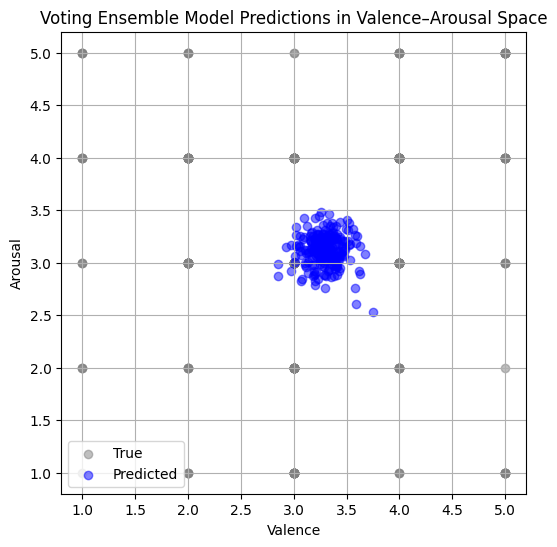

In [29]:
rates = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]
vl_predictions = sum(rate * model for rate, model in zip(rates, vl_models))
ar_predictions = sum(rate * model for rate, model in zip(rates, ar_models))
vl_ensemble_results.append(vl_predictions)
ar_ensemble_results.append(ar_predictions) 
ensemble_model_names.append("Voting Ensemble Model, 1/6 weights")
scatter_vl_ar(XGB_vl_test, vl_predictions, XGB_ar_test, ar_predictions, title="Voting Ensemble Model Predictions in Valence–Arousal Space")

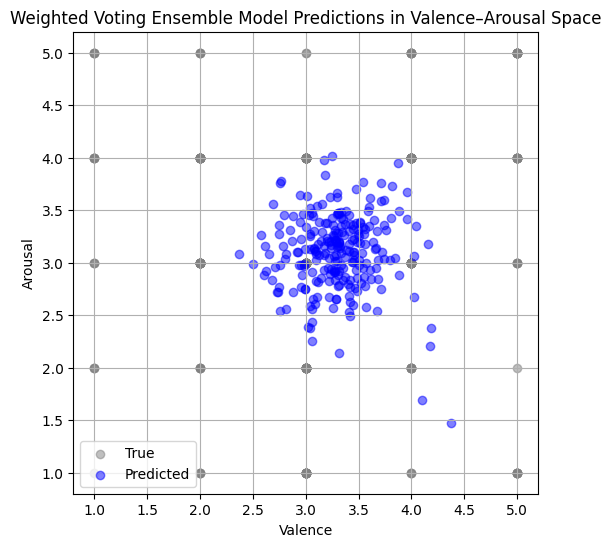

In [30]:
rates = [0.7, 0, 0, 0, 0.3, 0]
vl_predictions = sum(rate * model for rate, model in zip(rates, vl_models))
ar_predictions = sum(rate * model for rate, model in zip(rates, ar_models))
vl_ensemble_results.append(vl_predictions)
ar_ensemble_results.append(ar_predictions) 
ensemble_model_names.append("Voting Ensemble Model, RF 0.7, XGB 0.3")
scatter_vl_ar(XGB_vl_test, vl_predictions, XGB_ar_test, ar_predictions, title="Weighted Voting Ensemble Model Predictions in Valence–Arousal Space")

In [31]:
# linear regression ensemble

def linear_regression_ensemble(models, test_set, results_pred = False):
    X = np.column_stack(models)
    y = test_set
    lr_model = LinearRegression()
    lr_model.fit(X, y)
    
    predictions = lr_model.predict(X)
    
    mse, rmse, mae, spearman, pearson, ccc = regression_evaluation(y, predictions)

    #print weights of the linear regression model
    weights = lr_model.coef_
    print("Linear Regression Weights:", weights)
    
    if results_pred:
        return predictions
    else:
        return (mse, rmse, mae, spearman, pearson, ccc)

for label in ['vl_seg', 'ar_seg']:
    if label == 'vl_seg':
        test_set = vl_test
        model = vl_models
    else:
        test_set = ar_test
        model = ar_models
        
    results = linear_regression_ensemble(model, test_set)
    next_line = [f"Linear Regression Ensemble ({label})", label, 'LR Ensemble', ''] + list(results)
    
    for key, value in zip(ensemble_results.keys(), next_line):
        ensemble_results[key].append(value)



Linear Regression Weights: [  0.87649591  25.66662979 -23.79250743  -0.31150253   0.18952094
   1.06168871]
Linear Regression Weights: [ 0.206699   -1.87548245  1.26847738 -1.43150233  0.39580622  6.86310192]


Linear Regression Weights: [  0.87649591  25.66662979 -23.79250743  -0.31150253   0.18952094
   1.06168871]
Linear Regression Weights: [ 0.206699   -1.87548245  1.26847738 -1.43150233  0.39580622  6.86310192]


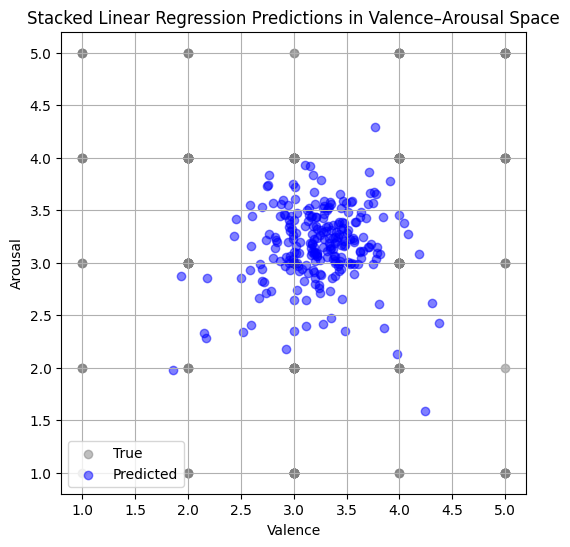

In [32]:
vl_predictions = linear_regression_ensemble(vl_models, vl_test, results_pred=True)
ar_predictions = linear_regression_ensemble(ar_models, ar_test, results_pred=True)
vl_ensemble_results.append(vl_predictions)
ar_ensemble_results.append(ar_predictions) 
ensemble_model_names.append("Stacked Linear Regression Model")
scatter_vl_ar(XGB_vl_test, vl_predictions, XGB_ar_test, ar_predictions, title="Stacked Linear Regression Predictions in Valence–Arousal Space")

In [33]:
# Save the ensemble results to csv
file_name = 'ensemble.csv'

results_df = pd.DataFrame(ensemble_results)
results_path = os.path.join(BASE_DIR, "../results/" + file_name)
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure directory exists
results_df.to_csv(results_path, index=False)
print(f"Results saved to {file_name}")


Results saved to ensemble.csv


In [34]:
def quadrants_eval(vl_true, vl_pred, ar_true, ar_pred):
    # Calculate the quadrants
      centre = 3
      threshold = 0.5

      HALV_true = (vl_true <= centre - threshold) & (ar_true >= centre + threshold).astype(int)
      HALV_pred = (vl_pred <= centre - threshold) & (ar_pred >= centre + threshold).astype(int)
      HALV_acc = accuracy_score(HALV_true, HALV_pred)
      HALV_f1 = f1_score(HALV_true, HALV_pred)

      HAHV_true = (vl_true >= centre + threshold) & (ar_true >= centre + threshold).astype(int)
      HAHV_pred = (vl_pred >= centre + threshold) & (ar_pred >= centre + threshold).astype(int)
      HAHV_acc = accuracy_score(HAHV_true, HAHV_pred)
      HAHV_f1 = f1_score(HAHV_true, HAHV_pred)
      
      LALV_true = (vl_true <= centre - threshold) & (ar_true <= centre - threshold).astype(int)
      LALV_pred = (vl_pred <= centre - threshold) & (ar_pred <= centre - threshold).astype(int)
      LALV_acc = accuracy_score(LALV_true, LALV_pred)
      LALV_f1 = f1_score(LALV_true, LALV_pred)

      LAHV_true = (vl_true >= centre + threshold) & (ar_true <= centre - threshold).astype(int)
      LAHV_pred = (vl_pred >= centre + threshold) & (ar_pred <= centre - threshold).astype(int)
      LAHV_acc = accuracy_score(LAHV_true, LAHV_pred)
      LAHV_f1 = f1_score(LAHV_true, LAHV_pred)

      N_true = ((vl_true > centre - threshold) & (vl_true < centre + threshold) & 
                (ar_true > centre - threshold) & (ar_true < centre + threshold)).astype(int)
      N_pred = ((vl_pred > centre - threshold) & (vl_pred < centre + threshold) & 
                (ar_pred > centre - threshold) & (ar_pred < centre + threshold)).astype(int)
      N_acc = accuracy_score(N_true, N_pred) 
      N_f1 = f1_score(N_true, N_pred)
      
      avg_acc = np.nanmean([HALV_acc, HAHV_acc, LALV_acc, LAHV_acc, N_acc])
      avg_f1 = np.nanmean([HALV_f1, HAHV_f1, LALV_f1, LAHV_f1, N_f1])

      return HALV_acc, HAHV_acc, LALV_acc, LAHV_acc, N_acc, avg_acc, HALV_f1, HAHV_f1, LALV_f1, LAHV_f1, N_f1, avg_f1

In [35]:
class_results = {
    "model": [],
    "HALV_acc": [],
    "HAHV_acc": [],
    "LALV_acc": [],
    "LAHV_acc": [],
    "N_acc": [],
    "avg_acc": [],
    "HALV_f1": [],
    "HAHV_f1": [],
    "LALV_f1": [],
    "LAHV_f1": [],
    "N_f1": [],
    "avg_f1": []
}

for i in range(len(vl_models)):
    vl_pred = vl_models[i]
    ar_pred = ar_models[i]
    vl_true = vl_test
    ar_true = ar_test
    model_name = model_names[i]

    HALV_acc, HAHV_acc, LALV_acc, LAHV_acc, N_acc, avg_acc, HALV_f1, HAHV_f1, LALV_f1, LAHV_f1, N_f1, avg_f1 = quadrants_eval(vl_true, vl_pred, ar_true, ar_pred)
    next_line = [model_name, HALV_acc, HAHV_acc, LALV_acc, LAHV_acc, N_acc, avg_acc, HALV_f1, HAHV_f1, LALV_f1, LAHV_f1, N_f1, avg_f1]
    for key, value in zip(class_results.keys(), next_line):
        class_results[key].append(value)

for i in range(len(vl_ensemble_results)):
    vl_pred = vl_ensemble_results[i]
    ar_pred = ar_ensemble_results[i]
    vl_true = vl_test
    ar_true = ar_test
    model_name = ensemble_model_names[i]

    print(len(vl_pred), len(ar_pred), vl_true.shape, ar_true.shape)

    HALV_acc, HAHV_acc, LALV_acc, LAHV_acc, N_acc, avg_acc, HALV_f1, HAHV_f1, LALV_f1, LAHV_f1, N_f1, avg_f1 = quadrants_eval(vl_true, vl_pred, ar_true, ar_pred)
    next_line = [model_name, HALV_acc, HAHV_acc, LALV_acc, LAHV_acc, N_acc, avg_acc, HALV_f1, HAHV_f1, LALV_f1, LAHV_f1, N_f1, avg_f1]
    for key, value in zip(class_results.keys(), next_line):
        class_results[key].append(value)

# Save the classification results to csv
file_name = 'quadrants_classification.csv'
results_df = pd.DataFrame(class_results)
results_path = os.path.join(BASE_DIR, "../results/" + file_name)   
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure directory exists
results_df.to_csv(results_path, index=False)
print(f"Results saved to {file_name}")

246 246 (246,) (246,)
246 246 (246,) (246,)
246 246 (246,) (246,)
Results saved to quadrants_classification.csv
